In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.dummy import DummyClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA

from skopt.space import Integer, Real, Categorical
from skopt import BayesSearchCV
from scipy.stats import uniform, loguniform, randint

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
import pickle

In [2]:
line_df = pd.read_csv('../data/csv/ShakespeareCharacterLines_engineered.csv', index_col = ['play', 'name', 'line_number'])

In [3]:
char_df = pd.read_csv('../data/csv/ShakespeareCharacterLines_character_corpus.csv', index_col = ['play', 'name'])

In [4]:
colon = slice(None)

- tragedy/comedy column for predictions, MNB, look for other things that work well on language data.

In [5]:
to_drop = list(line_df.columns[:10])
to_drop.remove('character_dies')

In [6]:
line_df.drop(columns = to_drop, inplace = True)
line_df = line_df.astype(dtype = np.float32)

In [7]:
line_xlist = line_df.columns.tolist()
line_xlist.remove('character_dies')

char_xlist = char_df.columns.tolist()
char_xlist.remove('character_dies')

line_X = line_df[line_xlist]
char_X = char_df[char_xlist]

line_y = line_df['character_dies']
char_y = char_df['character_dies']

line_X_train, line_X_test, line_y_train, line_y_test = train_test_split(line_X, line_y, random_state = 42, stratify = line_y)
char_X_train, char_X_test, char_y_train, char_y_test = train_test_split(char_X, char_y, random_state = 42, stratify = char_y)

sc = StandardScaler()
line_Xs_train = sc.fit_transform(line_X_train)
line_Xs_test = sc.transform(line_X_test)

char_Xs_train = sc.fit_transform(char_X_train)
char_Xs_test = sc.transform(char_X_test)

- Move PCA here with images.

- Baseline accuracy.

- Char logreg pipe.

In [30]:
char_df['character_dies'].value_counts(normalize = True)

0.0    0.905958
1.0    0.094042
Name: character_dies, dtype: float64

In [13]:
logreg_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('logreg', LogisticRegression(random_state = 42, solver = 'liblinear', penalty = 'l1'))
])

logreg_params = {
    'logreg__tol': uniform(0, .1),
    'logreg__C': loguniform(0.0001, 100),
    'logreg__class_weight': Categorical(['balanced', None]),
    'logreg__max_iter': randint(1, 1000),
    'logreg__l1_ratio': uniform(0, 1)
}

logreg_rs_rocauc = RandomizedSearchCV(estimator = logreg_pipe,
                     param_distributions = logreg_params,
                     scoring = 'roc_auc',
                     n_iter = 50,
                     n_jobs = 8,
                     cv = 5,
                     refit = True,
                     random_state=42)

In [14]:
%%time
logreg_rs_rocauc.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "


Wall time: 6min 54s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('sc', StandardScaler()),
                                             ('logreg',
                                              LogisticRegression(penalty='l1',
                                                                 random_state=42,
                                                                 solver='liblinear'))]),
                   n_iter=50, n_jobs=8,
                   param_distributions={'logreg__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002B2C298A340>,
                                        'logreg__class_weight': Categorical(categories=('balanced', None), prior=None),
                                        'logreg__l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002B2C298A940>,
                                        'logreg__max_iter': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002B1A806BC10>,
                                     

In [16]:
train_preds = logreg_rs_rocauc.best_estimator_['logreg'].predict(Xs_train)
test_preds = logreg_rs_rocauc.best_estimator_['logreg'].predict(Xs_test)

metrics.roc_auc_score(y_train, train_preds), metrics.roc_auc_score(y_test, test_preds)

(0.7990356819260473, 0.7135596471039509)

In [17]:
weights = {key: value for key, value in zip(x_list, logreg_rs_rocauc.best_estimator_['logreg'].coef_[0])}
weights = {k: v for k, v in sorted(weights.items(), key=lambda item: item[1], reverse = True)}

In [18]:
weights

{'death_std': 0.12850891631837966,
 'unwelcome_person_hyp_std': 0.07553806786164316,
 'neg_sentiment_std': 0.06891258369021096,
 'ah_std': 0.056450769581478766,
 'INTJ_std': 0.05121047413502336,
 'life_std': 0.050121440951676435,
 'denmark_syn_std': 0.043529132855568815,
 'word_std': 0.03470232159352246,
 'brow_std': 0.03214397083347529,
 'revenge_std': 0.031231511595154398,
 'mean_std': 0.025622324887338583,
 'eunuch_std': 0.02516520401919758,
 'win_hyp_std': 0.02442470233452667,
 'tragedy_std': 0.023730703162129035,
 'son_std': 0.018765378625682883,
 'abused_std': 0.018638307656687742,
 'murder_std': 0.017986973946210252,
 'being_hyp_std': 0.017760066284526407,
 'express_emotion_hyp_std': 0.01693803887373723,
 'villain_std': 0.01620860183951193,
 'dig_mean': 0.01565939980957762,
 'misconstrue_std': 0.014996624343505533,
 'unadvise_std': 0.0139210492888509,
 'undergo_hyp_mean': 0.01389503467035266,
 'standing_hyp_std': 0.01384963142253865,
 'writer_hyp_std': 0.012609478055652306,
 'ge

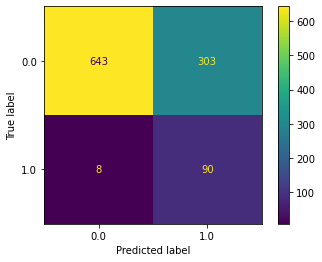

In [21]:
plot_confusion_matrix(logreg_rs_rocauc.best_estimator_['logreg'], Xs_train, y_train)

- Line NN with PCA.

In [17]:
line_pca = PCA(n_components = 10000, random_state = 42)
line_Z_train = pca.fit_transform(line_Xs_train)
line_Z_test = pca.transform(line_Xs_test)

In [37]:
%%time
clear_session()
line_model = Sequential()


line_model.add(Dense(100, input_dim = line_Z_train.shape[1], activation = 'relu', kernel_regularizer = l2(.01)))
line_model.add(Dropout(0.15))
line_model.add(Dense(100, activation = 'relu', kernel_regularizer = l2(.01)))
line_model.add(Dropout(0.15))
line_model.add(Dense(100, activation = 'relu', kernel_regularizer = l2(.01)))
line_model.add(Dropout(0.15))
line_model.add(Dense(1, activation = 'sigmoid'))

line_model.compile(loss = 'binary_crossentropy', optimizer = 'adam')

line_history = line_model.fit(line_Z_train, line_y_train, validation_data = (line_Z_test, line_y_test), batch_size = 512, 
                   epochs = 100, verbosity)

Epoch 1/100
47/47 [==============================] - 0s 6ms/step - loss: 3.7048 - val_loss: 2.8784
Epoch 2/100
47/47 [==============================] - 0s 4ms/step - loss: 2.3387 - val_loss: 1.8531
Epoch 3/100
47/47 [==============================] - 0s 4ms/step - loss: 1.5088 - val_loss: 1.2423
Epoch 4/100
47/47 [==============================] - 0s 4ms/step - loss: 1.0393 - val_loss: 0.9140
Epoch 5/100
47/47 [==============================] - 0s 4ms/step - loss: 0.7923 - val_loss: 0.7455
Epoch 6/100
47/47 [==============================] - 0s 4ms/step - loss: 0.6684 - val_loss: 0.6599
Epoch 7/100
47/47 [==============================] - 0s 4ms/step - loss: 0.6033 - val_loss: 0.6150
Epoch 8/100
47/47 [==============================] - 0s 4ms/step - loss: 0.5716 - val_loss: 0.5938
Epoch 9/100
47/47 [==============================] - 0s 4ms/step - loss: 0.5520 - val_loss: 0.5789
Epoch 10/100
47/47 [==============================] - 0s 4ms/step - loss: 0.5393 - val_loss: 0.5744
Epoch 11/

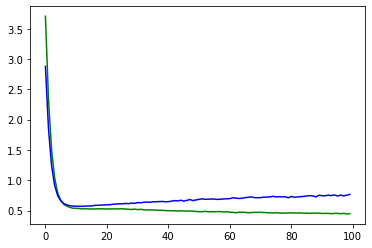

In [38]:
plt.plot(line_history.epoch, line_history.history['loss'], c='g');      # green - training loss # Loss
plt.plot(line_history.epoch, line_history.history['val_loss'], c='b');  # blue - test loss # Val loss

- Char NN with PCA.

In [10]:
pca = PCA(n_components = 1000, random_state = 42)
char_Z_train = pca.fit_transform(char_Xs_train)
char_Z_test = pca.transform(char_Xs_test)

In [14]:
%%time

model = Sequential()

model.add(Dense(30, activation = 'relu', input_shape = (1000,)))
model.add(Dense(30, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam')

history = model.fit(char_Z_train, char_y_train, validation_data = (char_Z_test, char_y_test), batch_size = 512, 
                   epochs = 1000)

Epoch 1/1000
3/3 [==============================] - 0s 45ms/step - loss: 4.1261 - val_loss: 1.9712
Epoch 2/1000
3/3 [==============================] - 0s 4ms/step - loss: 2.5643 - val_loss: 1.5581
Epoch 3/1000
3/3 [==============================] - 0s 4ms/step - loss: 1.6109 - val_loss: 1.2297
Epoch 4/1000
3/3 [==============================] - 0s 5ms/step - loss: 1.0173 - val_loss: 0.9994
Epoch 5/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.6514 - val_loss: 0.8546
Epoch 6/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.4428 - val_loss: 0.7589
Epoch 7/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.3049 - val_loss: 0.6961
Epoch 8/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.2183 - val_loss: 0.6498
Epoch 9/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.1650 - val_loss: 0.6156
Epoch 10/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.1273 - val_loss: 0.5913
Epoch 11/1000
3/3 

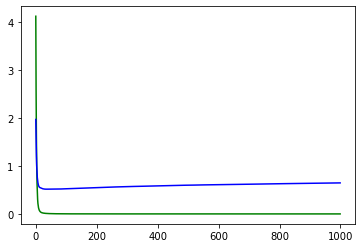

In [15]:
plt.plot(history.epoch, history.history['loss'], c='g');      # green - training loss # Loss
plt.plot(history.epoch, history.history['val_loss'], c='b');  # blue - test loss # Val loss

In [ ]:
#credit to: lesson 7.6
def model_func(layers, loss_fn = 'binary_crossentropy'):
    
    model = Sequential()

    flag_first = True
    
    for layer in layers:
        if flag_first:
            model.add(Dense(layer, activation = 'relu', input_shape = (14258,)))
            flag_first = False
        else:
            model.add(Dense(layer, activation = 'relu'))
    
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss = loss_fn, optimizer = 'adam')
    
    return model

nn = KerasClassifier(build_fn = model, batch_size = 512, epochs = 20, verbose = 0)

params = {'batch_size': [126, 512],
          'epochs': [10, 15, 20]
         }

grid = GridSearchCV(nn, params, cv = 3, n_jobs = -1)

In [ ]:
%%time
sc = StandardScaler()
Xs_train = sc.fit_transform(X_train)
grid.fit(Xs_train, y_train)